## Notebook to find the 'mean' image for all images of each class (6 classes total)

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pydicom as dcm
import sys
import os
import tensorflow as tf
import logging
from tqdm import tqdm
import gc
from joblib import Parallel, delayed
%matplotlib inline

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
def preprocess_dcm(file_path, normalize=False):
    ds = dcm.dcmread(file_path)
    try:
        ds = tf.convert_to_tensor(ds.pixel_array, dtype=tf.dtypes.int32)
    except:
        return tf.zeros((512,512))
    if normalize:
        ds /= tf.reduce_max(tf.abs(ds))
    return ds

In [4]:
img_path = '/home/jupyter/rsna-intracranial-hemorrhage-detection/stage_2_train/'
img = tf.zeros((512,512), dtype=tf.dtypes.int32)
def mean_image(labels, subtype_name, comp_val=True):
    class_labels = labels[labels[subtype_name] == comp_val]
    
    
    def add_img(img_id):
        global img
        next_img = preprocess_dcm(img_path+img_id+'.dcm')
        if next_img.shape == (512,512):
            img = tf.add(img, next_img)
    
    Parallel(n_jobs=1)(delayed(add_img)(img_id) for img_id in tqdm(class_labels.index))

    return img #/ tf.reduce_max(tf.abs(img))

2021-11-29 07:15:37.935115: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-29 07:15:38.657428: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 36827 MB memory:  -> device: 0, name: A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0


In [5]:
labels = pd.read_csv('/home/jupyter/rsna-intracranial-hemorrhage-detection/train_labels.csv', index_col=0)
labels.head()

,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
ID,,,,,,
ID_000012eaf,False,False,False,False,False,False
ID_000039fa0,False,False,False,False,False,False
ID_00005679d,False,False,False,False,False,False
ID_00008ce3c,False,False,False,False,False,False
ID_0000950d7,False,False,False,False,False,False


## (1) Mean image for scans with epidural hemorrhage

100%|██████████| 3145/3145 [00:05<00:00, 627.01it/s]


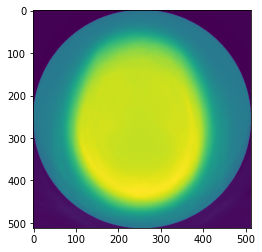

In [6]:
mean_epidural = mean_image(labels, 'epidural', comp_val=True)
plt.imshow(mean_epidural)

## (2) Mean image for scans with intraparenchymal hemorrhage

100%|██████████| 36118/36118 [14:07<00:00, 42.63it/s]


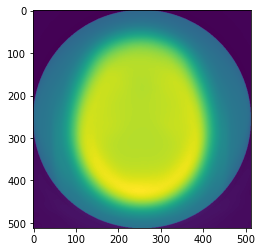

In [7]:
mean_intraparenchymal = mean_image(labels, 'intraparenchymal', comp_val=True)
plt.imshow(mean_intraparenchymal)

100%|██████████| 26205/26205 [10:02<00:00, 43.50it/s]


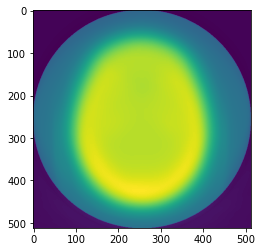

In [8]:
mean_intraventricular = mean_image(labels, 'intraventricular', comp_val=True)
plt.imshow(mean_intraventricular)

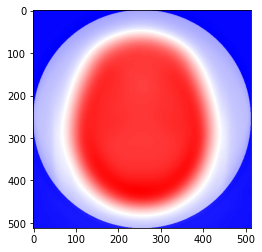

In [9]:
contrast_mean = mean_intraventricular - mean_epidural
plt.imshow(contrast_mean, cmap='bwr')

After a rough investigation, it appears that looking at the mean value images for each class does not provide much easily distinguishable information, so the differences between each class must be more subtle than this. Indeed, we can see that the images are each slices of CT scans, each scanning a different cross-section of the skull, so the same type of hemorrhage may look different in different scans.